In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import transforms3d as tf3d


In [2]:
mass=369 #batterie
mass+=1640-114 #corps-carton
mass/=1e3
Area=np.pi*(11.0e-02)**2
r0=11e-02
rho0=1.204
kv_motor=800.0
pwmmin=1075.0
pwmmax=1950.0
U_batt=16.8

b10=14.44

In [3]:
# %%   ####### IMPORT DATA 
print("LOADING DATA...")


log_path="./logs/copter/vol12/log_real_processed.csv"

raw_data=pd.read_csv(log_path)

print("PROCESSING DATA...")


prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])
# print(prep_data)

if "vol12" in log_path:
    tmin,tmax=(-1,1e10) 
elif "vol1" in log_path:
    tmin,tmax=(41,265) 
elif "vol2" in log_path:
    tmin,tmax=(10,140) 
    
prep_data=prep_data[prep_data['t']>tmin]
prep_data=prep_data[prep_data['t']<tmax]
prep_data=prep_data.reset_index()
for i in range(3):
    prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
    
    

prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
prep_data['t']-=prep_data['t'][0]
prep_data=prep_data.drop(index=[0,len(prep_data)-1])




for i in range(6):
    prep_data['omega_c[%i]'%(i+1)]=(prep_data['PWM_motor[%i]'%(i+1)]-pwmmin)/(pwmmax-pwmmin)*U_batt*kv_motor*2*np.pi/60


LOADING DATA...
PROCESSING DATA...


c1 :0.000006 ,c2: VANILLA ,cost :1.499342
c1 :0.000006 ,c2: VANILLA ,cost :1.510869
c1 :-773575.641559 ,c2: VANILLA ,cost :1693611007296560559030272.000000
c1 :-77357.564150 ,c2: VANILLA ,cost :16936110072915046694912.000000
c1 :-7735.756410 ,c2: VANILLA ,cost :169361100724055900160.000000
c1 :-773.575636 ,c2: VANILLA ,cost :1693611006731346176.000000
c1 :-77.357558 ,c2: VANILLA ,cost :16936110016391784.000000
c1 :-7.735750 ,c2: VANILLA ,cost :169361095071760.250000
c1 :-0.773570 ,c2: VANILLA ,cost :1693610441502.894043
c1 :-0.077352 ,c2: VANILLA ,cost :16936053494.897030
c1 :-0.007730 ,c2: VANILLA ,cost :169355444.271659
c1 :-0.000768 ,c2: VANILLA ,cost :1693046.710899


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


c1 :-0.000071 ,c2: VANILLA ,cost :16881.029841
c1 :-0.000071 ,c2: VANILLA ,cost :16874.516662
c1 :0.000006 ,c2: VANILLA ,cost :1.452245
c1 :0.000006 ,c2: VANILLA ,cost :1.452245

 

c1 :0.000000 ,c2: 0.000000,cost :98.996004
c1 :0.000000 ,c2: 0.000000,cost :98.995730
c1 :0.000000 ,c2: 0.000000,cost :98.996007
c1 :18402.674053 ,c2: -173.822436,cost :1700453389546048.000000
c1 :1840.267405 ,c2: -17.382244,cost :5203666218048.857422
c1 :184.026741 ,c2: -1.738224,cost :35230583521.966927
c1 :18.402674 ,c2: -0.173822,cost :310952962.869413
c1 :1.840267 ,c2: -0.017382,cost :2959331.111034
c1 :0.184027 ,c2: -0.001738,cost :26268.135257
c1 :0.018403 ,c2: -0.000174,cost :54.520658
c1 :0.018403 ,c2: -0.000174,cost :54.520861
c1 :0.018403 ,c2: -0.000174,cost :54.520638
c1 :35.003306 ,c2: 719.986096,cost :40.081405
c1 :17.511341 ,c2: 360.002979,cost :40.042495
c1 :8.765360 ,c2: 180.011447,cost :39.964746
c1 :4.392372 ,c2: 90.015736,cost :39.809525
c1 :2.205883 ,c2: 45.017989,cost :39.500200
c1 :1.

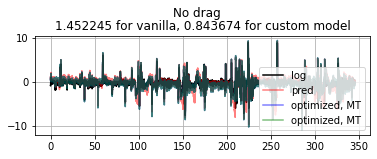

In [4]:

# %%   ####### Identify Thrust 

def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T


def compute_single_motor_thrust_BET(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k



def cost_vanilla(X):
    c1=X
    Y=compute_acc_k(c1,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: VANILLA ,cost :%f"%(c1,c))
    return c

X0_vanilla=np.array([6e-6])

sol_vanilla=minimize(cost_vanilla,X0_vanilla,method="SLSQP")
c1vanilla=sol_vanilla['x']
print("\n \n")

def cost(X):
    c1,c2=X
    Y=compute_acc_k(c1,c2=c2)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: %f,cost :%f"%(c1,c2,c))
    return c


X0=np.zeros(2)
sol_custom=minimize(cost,X0,method="SLSQP")

c1sol,c2sol=sol_custom['x']
# %%% Comparison

f=plt.figure()
f.suptitle("No drag")
ax=f.add_subplot(2,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k(c1vanilla,vanilla=True),color="red",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k(c1sol,c2=c2sol,model="MT"),color="blue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k(c1sol,c2=c2sol,model="BET"),color="green",label="optimized, MT",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model"%(sol_vanilla['fun'],sol_custom['fun'])
print(s)
ax.set_title(s)

print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k(c1sol,c2=c2sol,model="MT")-compute_acc_k(c1sol,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))


In [5]:

# %%   ####### Identify Thrust(with dk)


def compute_single_motor_thrust_MT_wdrag(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T


def compute_single_motor_thrust_BET_wdrag(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k_wdrag(c1,dk,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma-rho0*Area*dk*np.abs(vak)*vak
    
    return acc_k

from scipy.optimize import minimize

import matplotlib.pyplot as plt


def cost_vanilla_wdrag(X):
    c1,dk=X
    Y=compute_acc_k_wdrag(c1,dk,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: VANILLA , dk: %f ,cost :%f"%(c1,dk,c))
    return c

X0_vanilla=np.array([6e-6,0])

sol_vanilla_drag=minimize(cost_vanilla_wdrag,X0_vanilla,method="SLSQP")
c1vanilla,dkvanilla=sol_vanilla_drag['x']


def cost_wdrag(X):
    c1,c2,dk=X
    Y=compute_acc_k_wdrag(c1,dk,c2=c2)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: %f, dk: %f , cost :%f"%(c1,c2,dk,c))
    return c


X0=np.zeros(3)
sol_custom_drag=minimize(cost_wdrag,X0,method="SLSQP")

c1sol,c2sol,dksol=sol_custom_drag['x']

# %%% Comparison

f.suptitle("Thrust no drag / With drag")
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1vanilla,dkvanilla,vanilla=True),color="red",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT"),color="blue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"),color="green",label="optimized, MT",alpha=0.5)
ax.legend()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model"%(sol_vanilla_drag['fun'],sol_custom_drag['fun'])
ax.set_title(s)
print(s)


print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT")-compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))

# %%% Comparison
f.suptitle("Vanilla / Augmented with drag")
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1vanilla,dkvanilla,vanilla=True),color="darkred",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT"),color="darkblue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"),color="darkgreen",label="optimized, MT",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
print("%f for vanilla, %f for custom model"%(sol_vanilla_drag['fun'],sol_custom_drag['fun']))


print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k_wdrag(c1sol,dkvanilla,c2=c2sol,model="MT")-compute_acc_k_wdrag(c1sol,dkvanilla,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))


c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :1.499342
c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :1.510869
c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :1.499342
c1 :-773575.641559 ,c2: VANILLA , dk: 0.542228 ,cost :1693611007296743095140352.000000
c1 :-77357.564150 ,c2: VANILLA , dk: 0.054223 ,cost :16936110072916802011136.000000
c1 :-7735.756410 ,c2: VANILLA , dk: 0.005422 ,cost :169361100724073070592.000000
c1 :-773.575636 ,c2: VANILLA , dk: 0.000542 ,cost :1693611006731525120.000000
c1 :-77.357558 ,c2: VANILLA , dk: 0.000054 ,cost :16936110016393626.000000
c1 :-7.735750 ,c2: VANILLA , dk: 0.000005 ,cost :169361095071777.843750
c1 :-0.773570 ,c2: VANILLA , dk: 0.000001 ,cost :1693610441503.066650
c1 :-0.077352 ,c2: VANILLA , dk: 0.000000 ,cost :16936053494.898766
c1 :-0.007730 ,c2: VANILLA , dk: 0.000000 ,cost :169355444.271676


/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


c1 :-0.000768 ,c2: VANILLA , dk: 0.000000 ,cost :1693046.710900
c1 :-0.000071 ,c2: VANILLA , dk: 0.000000 ,cost :16881.029841
c1 :-0.000071 ,c2: VANILLA , dk: 0.000000 ,cost :16874.516662
c1 :-0.000071 ,c2: VANILLA , dk: 0.000000 ,cost :16881.029842
c1 :0.000006 ,c2: VANILLA , dk: 0.485606 ,cost :1.238681
c1 :0.000006 ,c2: VANILLA , dk: 0.485606 ,cost :1.238681
c1 :0.000006 ,c2: VANILLA , dk: 0.485606 ,cost :1.238681
c1 :0.000006 ,c2: VANILLA , dk: 0.873406 ,cost :1.102229
c1 :0.000006 ,c2: VANILLA , dk: 0.873406 ,cost :1.102258
c1 :0.000006 ,c2: VANILLA , dk: 0.873406 ,cost :1.102229
c1 :0.000006 ,c2: VANILLA , dk: 2.410871 ,cost :0.859434
c1 :0.000006 ,c2: VANILLA , dk: 2.410871 ,cost :0.859434
c1 :0.000006 ,c2: VANILLA , dk: 2.410871 ,cost :0.859434
c1 :0.000000 ,c2: 0.000000, dk: 0.000000 , cost :98.996004
c1 :0.000000 ,c2: 0.000000, dk: 0.000000 , cost :98.995730
c1 :0.000000 ,c2: 0.000000, dk: 0.000000 , cost :98.996007
c1 :0.000000 ,c2: 0.000000, dk: 0.000000 , cost :98.996004
c

In [6]:

# %%%   ####### Identify pure drag

def compute_ai_od(di,df=prep_data):
    
    vak=df["speed_body[0]"]
    Fa=-rho0*Area*di*np.abs(vak)*vak
    gamma=df["gamma[0]"]

    return Fa+gamma

def cost_ai_onlydrag(X):
    di=X
    
    Y=compute_ai_od(di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("di :%f , cost :%f"%(di,c))

    return c
    
X0_di_onlydrag=np.array([0])

sol_ai_od=minimize(cost_ai_onlydrag,X0_di_onlydrag,method="SLSQP")
di_only_=sol_ai_od['x']
print("\n \n")


di :0.000000 , cost :0.647981
di :0.000000 , cost :0.647981
di :1.886418 , cost :3.200308
di :0.549261 , cost :0.129913
di :0.549261 , cost :0.129913

 



In [7]:

# %%%   ####### Identify H-force nodrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_ai_H_only(ch1,ch2,df=prep_data):

    vai=df["speed_body[0]"]
    vak=df["speed_body[2]"]

    gamma=df["gamma[0]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vai*H
    
    return H_vect+gamma

def cost_ai_h_only(X):
    ch1,ch2=X

    Y=compute_ai_H_only(ch1,ch2)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_ai_onlyh=np.array([0,0])

sol_ai_oh=minimize(cost_ai_h_only,X0_ai_onlyh,method="SLSQP")
ch1_ai_only_,ch2_ai_only_=sol_ai_oh['x']
print("\n \n")

ch1 :0.000000 , ch2 :0.000000 , cost :0.647981
ch1 :0.000000 , ch2 :0.000000 , cost :0.647980
ch1 :0.000000 , ch2 :0.000000 , cost :0.647981
ch1 :100.473131 , ch2 :-9.123066 , cost :44647199.257440
ch1 :10.047313 , ch2 :-0.912307 , cost :445556.606249
ch1 :1.004731 , ch2 :-0.091231 , cost :4364.604781
ch1 :0.100473 , ch2 :-0.009123 , cost :35.127271
ch1 :0.011450 , ch2 :-0.001040 , cost :0.068046
ch1 :0.011450 , ch2 :-0.001040 , cost :0.068046
ch1 :0.011450 , ch2 :-0.001040 , cost :0.068046
ch1 :-0.000709 , ch2 :-0.136983 , cost :0.064922
ch1 :-0.000709 , ch2 :-0.136983 , cost :0.064922
ch1 :-0.000709 , ch2 :-0.136983 , cost :0.064922
ch1 :0.004145 , ch2 :-0.082715 , cost :0.062451
ch1 :0.004145 , ch2 :-0.082715 , cost :0.062451
ch1 :0.004145 , ch2 :-0.082715 , cost :0.062451

 



In [8]:

# %%%   ####### Identify H-force wdrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_ai_H_wdrag(ch1,ch2,di,df=prep_data):
    
    vai=df["speed_body[0]"]
    vak=df["speed_body[2]"]

    gamma=df["gamma[0]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vai*H
    Fa=-rho0*Area*di*np.abs(vai)*vai

    return H_vect+gamma+Fa

def cost_ai_h_wdrag(X):
    ch1,ch2,di=X

    Y=compute_ai_H_wdrag(ch1,ch2,di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , di :%f , cost :%f"%(ch1,ch2,di,c))

    return c

X0_ai_hwd=np.array([0,0,0])

sol_ai_hwd=minimize(cost_ai_h_wdrag,X0_ai_hwd,method="SLSQP")
ch1_ai_wd_,ch2_ai_wd_,di_wd_=sol_ai_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.647981
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.647980
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.647981
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.647981
ch1 :100.473131 , ch2 :-9.123066 , di :1.886418 , cost :44678123.690230
ch1 :10.047313 , ch2 :-0.912307 , di :0.188642 , cost :445865.530305
ch1 :1.004731 , ch2 :-0.091231 , di :0.018864 , cost :4367.661995
ch1 :0.100473 , ch2 :-0.009123 , di :0.001886 , cost :35.154640
ch1 :0.011446 , ch2 :-0.001039 , di :0.000215 , cost :0.068042
ch1 :0.011446 , ch2 :-0.001039 , di :0.000215 , cost :0.068042
ch1 :0.011446 , ch2 :-0.001039 , di :0.000215 , cost :0.068042
ch1 :0.011446 , ch2 :-0.001039 , di :0.000215 , cost :0.068042
ch1 :-0.001050 , ch2 :-0.136938 , di :0.018566 , cost :0.064812
ch1 :-0.001050 , ch2 :-0.136938 , di :0.018566 , cost :0.064812
ch1 :-0.001050 , ch2 :-0.136938 , di :0.018566 , cost :0.064812
ch1 :-0.001050 , ch2 :-0.136938 , di 


Performances: 
RMS error on acc pred is : 
0.129913 for vanilla, 0.062451 for custom model, 0.062243 for full model
dj :1.000000 , cost :0.348908
dj :1.000000 , cost :0.348908
dj :0.165979 , cost :0.395209
dj :0.609015 , cost :0.185863
dj :0.609015 , cost :0.185863

 



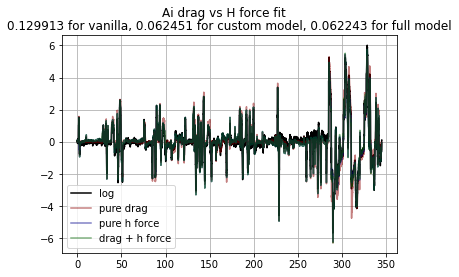

In [9]:

# %%%   ####### Comparison

f=plt.figure()
f.suptitle("Ai drag vs H force fit")
ax=f.add_subplot(1,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],compute_ai_H_only(ch1_ai_only_,ch2_ai_only_),color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],compute_ai_H_wdrag(ch1_ai_only_,ch2_ai_only_,di_wd_),color="darkgreen",label="drag + h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model, %f for full model"%(sol_ai_od['fun'],sol_ai_oh['fun'],sol_ai_hwd['fun'])
ax.set_title(s)
print(s)

# %% aj
# %%%   ####### Identify pure drag

def compute_aj_od(dj,df=prep_data):
    
    vak=df["speed_body[1]"]
    Fa=-rho0*Area*dj*np.abs(vak)*vak
    gamma=df["gamma[1]"]

    return Fa+gamma

def cost_aj_onlydrag(X):
    dj=X
    
    Y=compute_aj_od(dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("dj :%f , cost :%f"%(dj,c))

    return c
    
X0_dj_onlydrag=np.array([1])

sol_aj_od=minimize(cost_aj_onlydrag,X0_dj_onlydrag,method="SLSQP")
dj_only_=sol_aj_od['x']
print("\n \n")

In [10]:


# %%%   ####### Identify H-force nodrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_aj_H_only(ch1,ch2,df=prep_data):
    
    vak=df["speed_body[2]"]
    vaj=df["speed_body[1]"]

    gamma=df["gamma[1]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vaj*H
    
    return H_vect+gamma

def cost_aj_h_only(X):
    ch1,ch2=X

    Y=compute_aj_H_only(ch1,ch2)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_aj_onlyh=np.array([0,0])

sol_aj_oh=minimize(cost_aj_h_only,X0_aj_onlyh,method="SLSQP")
ch1_aj_only_,ch2_aj_only_=sol_aj_oh['x']
print("\n \n")


ch1 :0.000000 , ch2 :0.000000 , cost :0.581451
ch1 :0.000000 , ch2 :0.000000 , cost :0.581449
ch1 :0.000000 , ch2 :0.000000 , cost :0.581451
ch1 :82.590999 , ch2 :-7.149548 , cost :26030546.817097
ch1 :8.259100 , ch2 :-0.714955 , cost :259687.528368
ch1 :0.825910 , ch2 :-0.071495 , cost :2535.599376
ch1 :0.082591 , ch2 :-0.007150 , cost :19.746475
ch1 :0.010900 , ch2 :-0.000944 , cost :0.127971
ch1 :0.010900 , ch2 :-0.000944 , cost :0.127971
ch1 :0.010900 , ch2 :-0.000944 , cost :0.127971
ch1 :-0.001964 , ch2 :-0.152789 , cost :0.121002
ch1 :-0.001964 , ch2 :-0.152789 , cost :0.121002
ch1 :-0.001964 , ch2 :-0.152789 , cost :0.121002
ch1 :0.001710 , ch2 :-0.109422 , cost :0.119676
ch1 :0.001710 , ch2 :-0.109422 , cost :0.119676
ch1 :0.001710 , ch2 :-0.109422 , cost :0.119676

 



In [11]:

# %%%   ####### Identify H-force wdrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_aj_H_wdrag(ch1,ch2,dj,df=prep_data):
    
    vak=df["speed_body[2]"]
    vaj=df["speed_body[1]"]

    gamma=df["gamma[1]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=-vaj*H
    Fa=-rho0*Area*dj*np.abs(vaj)*vaj

    return H_vect+gamma+Fa

def cost_aj_h_wdrag(X):
    ch1,ch2,dj=X

    Y=compute_aj_H_wdrag(ch1,ch2,dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , dj :%f , cost :%f"%(ch1,ch2,dj,c))

    return c

X0_aj_hwd=np.array([0,0,0])

sol_aj_hwd=minimize(cost_aj_h_wdrag,X0_aj_hwd,method="SLSQP")
ch1_aj_wd_,ch2_aj_wd_,dj_wd_=sol_aj_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.581451
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.581449
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.581451
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :0.581451
ch1 :82.590999 , ch2 :-7.149548 , dj :1.299107 , cost :26043089.999235
ch1 :8.259100 , ch2 :-0.714955 , dj :0.129911 , cost :259812.808298
ch1 :0.825910 , ch2 :-0.071495 , dj :0.012991 , cost :2536.836986
ch1 :0.082591 , ch2 :-0.007150 , dj :0.001299 , cost :19.757333
ch1 :0.010897 , ch2 :-0.000943 , dj :0.000171 , cost :0.127966
ch1 :0.010897 , ch2 :-0.000943 , dj :0.000171 , cost :0.127966
ch1 :0.010897 , ch2 :-0.000943 , dj :0.000171 , cost :0.127966
ch1 :0.010897 , ch2 :-0.000943 , dj :0.000171 , cost :0.127966
ch1 :-0.002346 , ch2 :-0.152748 , dj :0.025014 , cost :0.120665
ch1 :-0.002346 , ch2 :-0.152748 , dj :0.025014 , cost :0.120665
ch1 :-0.002346 , ch2 :-0.152748 , dj :0.025014 , cost :0.120665
ch1 :-0.002346 , ch2 :-0.152748 , dj :0


Performances: 
RMS error on acc pred is : 
0.185863 for vanilla 
 0.119676 for custom model 
 0.119103 for full model


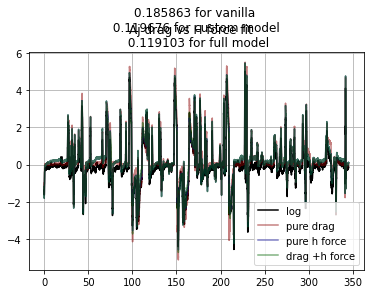

In [12]:
# %%%   ####### Comparison

f=plt.figure()
f.suptitle("Aj drag vs H force fit")
ax=f.add_subplot(1,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],compute_aj_H_only(ch1_aj_only_,ch2_aj_only_),color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],compute_aj_H_wdrag(ch1_aj_only_,ch2_aj_only_,dj_wd_),color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aj_od['fun'],sol_aj_oh['fun'],sol_aj_hwd["fun"])
ax.set_title(s)
print(s)
# %% aij

In [13]:


# %%% H nodrag

def compute_aij_H_wdrag(ch1,ch2,di=0,dj=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]

    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=np.c_[-vai*H,-vaj*H]
    
    Fa=-rho0*Area*np.c_[di*np.abs(vai)*vai,dj*np.abs(vaj)*vaj]

    return H_vect+np.c_[gammai,gammaj]+Fa

def cost_aij_h_nodrag(X):
    ch1,ch2=X
    Y=compute_aij_H_wdrag(ch1,ch2,di=0,dj=0)
    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_aij_nodrag=np.array([0,0])

sol_aij_nodrag=minimize(cost_aij_h_nodrag,X0_aij_nodrag,method="SLSQP")
ch1_aij_nodrag_,ch2_aij_nodrag_=sol_aij_nodrag['x']



ch1 :0.000000 , ch2 :0.000000 , cost :1.229432
ch1 :0.000000 , ch2 :0.000000 , cost :1.229429
ch1 :0.000000 , ch2 :0.000000 , cost :1.229432
ch1 :183.064130 , ch2 :-16.272615 , cost :276137901.068686
ch1 :18.306413 , ch2 :-1.627261 , cost :2758340.271196
ch1 :1.830641 , ch2 :-0.162726 , cost :27280.624186
ch1 :0.183064 , ch2 :-0.016273 , cost :243.623813
ch1 :0.018306 , ch2 :-0.001627 , cost :0.613419
ch1 :0.018306 , ch2 :-0.001627 , cost :0.613421
ch1 :0.018306 , ch2 :-0.001627 , cost :0.613419
ch1 :-0.014835 , ch2 :-0.299338 , cost :0.248376
ch1 :-0.014835 , ch2 :-0.299338 , cost :0.248376
ch1 :-0.014835 , ch2 :-0.299338 , cost :0.248376
ch1 :0.022304 , ch2 :0.149178 , cost :0.309734
ch1 :0.000494 , ch2 :-0.114215 , cost :0.188476
ch1 :0.000494 , ch2 :-0.114215 , cost :0.188476
ch1 :0.000494 , ch2 :-0.114215 , cost :0.188476
ch1 :0.003128 , ch2 :-0.094179 , cost :0.182461
ch1 :0.003128 , ch2 :-0.094179 , cost :0.182462
ch1 :0.003128 , ch2 :-0.094179 , cost :0.182461
ch1 :0.002941 , c

In [14]:


# %%% H wd


def cost_aij_h_wdrag(X):
    ch1,ch2,di,dj=X

    Y=compute_aij_H_wdrag(ch1,ch2,di,dj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj

    print("ch1 :%f , ch2 :%f , di :%f , dj : %f , cost :%f"%(ch1,ch2,di,dj,c))

    return c

X0_aij_hwd=np.array([0,0,0,0])

sol_aij_hwd=minimize(cost_aij_h_wdrag,X0_aij_hwd,method="SLSQP")
ch1_aij_wd_,ch2_aij_wd_,di_aij_wd_,dj_aij_wd_=sol_aij_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.229432
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.229429
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.229432
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.229432
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.229432
ch1 :183.064130 , ch2 :-16.272615 , di :1.886418 , dj : 1.299107 , cost :276222041.803343
ch1 :18.306413 , ch2 :-1.627261 , di :0.188642 , dj : 0.129911 , cost :2759181.206379
ch1 :1.830641 , ch2 :-0.162726 , di :0.018864 , dj : 0.012991 , cost :27288.986322
ch1 :0.183064 , ch2 :-0.016273 , di :0.001886 , dj : 0.001299 , cost :243.702713
ch1 :0.018306 , ch2 :-0.001627 , di :0.000189 , dj : 0.000130 , cost :0.613736
ch1 :0.018306 , ch2 :-0.001627 , di :0.000189 , dj : 0.000130 , cost :0.613737
ch1 :0.018306 , ch2 :-0.001627 , di :0.000189 , dj : 0.000130 , cost :0.613736
ch1 :0.018306 , ch2 :-0.001627 , 


Performances: 
RMS error on acc pred is : 
0.129913 for vanilla 
  0.062602 for custom model 
 0.062405 for full model

Performances: 
RMS error on acc pred is : 
0.185863 for vanilla 
 2.429506 for custom model 
 2.435867 for full model


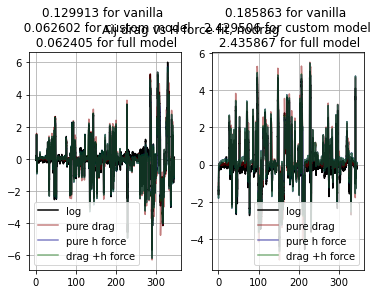

In [15]:



# %%% Comparison ai
aind,ajnd=compute_aij_H_wdrag(ch1_aij_nodrag_,ch2_aij_nodrag_).T
aid,ajd=compute_aij_H_wdrag(ch1_aij_wd_,ch2_aij_wd_,di_aij_wd_,dj_aij_wd_).T

f=plt.figure()
f.suptitle("Aij drag vs H force fit, nodrag")
ax=f.add_subplot(1,2,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],aind,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],aid,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_nd=np.mean((aind-prep_data['acc_body_grad[0]'])**2,axis=0)
c_i_d=np.mean((aid-prep_data['acc_body_grad[0]'])**2,axis=0)                            
s="%f for vanilla \n  %f for custom model \n %f for full model"%(sol_ai_od['fun'],c_i_nd,c_i_d)
ax.set_title(s)
print(s)

# %%% Comparison aj

ax=f.add_subplot(1,2,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],ajnd,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],ajd,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_j_nd=np.mean((ajnd-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_d=np.mean((ajd-prep_data['acc_body_grad[0]'])**2,axis=0)  
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aj_od['fun'],c_j_nd,c_j_d)
ax.set_title(s)
print(s)



In [16]:


# %% aij (di_eq_dj)
 
# %%% H nodrag

def compute_aij_H_wdrag(ch1,ch2,di=0,dj=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]

    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    H_vect=np.c_[-vai*H,-vaj*H]
    
    Fa=-rho0*Area*np.c_[di*np.abs(vai)*vai,dj*np.abs(vaj)*vaj]

    return H_vect+np.c_[gammai,gammaj]+Fa


# %%% H wd


def cost_aij_h_wdrag_di_eq_dj_(X):
    ch1,ch2,di=X

    Y=compute_aij_H_wdrag(ch1,ch2,di,di)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj

    print("ch1 :%f , ch2 :%f , dij :%f  , cost :%f"%(ch1,ch2,di,c))

    return c

X0_aij_hwd_di_eq_dj_=np.array([0,0,0])

sol_aij_hwd_di_eq_dj_=minimize(cost_aij_h_wdrag_di_eq_dj_,X0_aij_hwd_di_eq_dj_,method="SLSQP")
ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_=sol_aij_hwd_di_eq_dj_['x']


ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :1.229432
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :1.229429
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :1.229432
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :1.229432
ch1 :183.064130 , ch2 :-16.272615 , dij :3.185525  , cost :276301228.872827
ch1 :18.306413 , ch2 :-1.627261 , dij :0.318553  , cost :2759972.635956
ch1 :1.830641 , ch2 :-0.162726 , dij :0.031855  , cost :27296.856506
ch1 :0.183064 , ch2 :-0.016273 , dij :0.003186  , cost :243.777003
ch1 :0.018306 , ch2 :-0.001627 , dij :0.000319  , cost :0.614038
ch1 :0.018306 , ch2 :-0.001627 , dij :0.000319  , cost :0.614039
ch1 :0.018306 , ch2 :-0.001627 , dij :0.000319  , cost :0.614037
ch1 :0.018306 , ch2 :-0.001627 , dij :0.000319  , cost :0.614038
ch1 :-0.015690 , ch2 :-0.299230 , dij :0.050492  , cost :0.249412
ch1 :-0.015690 , ch2 :-0.299230 , dij :0.050492  , cost :0.249412
ch1 :-0.015690 , ch2 :-0.299230 , dij :0.050492  , cost :0.249412
ch


Performances: 
RMS error on acc pred is : 
0.181691 for vanilla 
 0.065242 for custom model 
 0.062396 for full model

Performances: 
RMS error on acc pred is : 
0.181691 for vanilla 
 2.428160 for custom model 
 2.435418 for full model


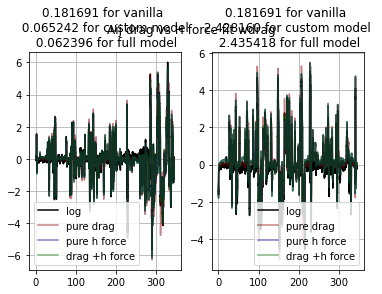

In [17]:


# %%% Comparison ai
aind,ajnd=compute_aij_H_wdrag(ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_).T
aid,ajd=compute_aij_H_wdrag(ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_).T

f=plt.figure()
f.suptitle("Aij drag vs H force fit wdrag")
ax=f.add_subplot(1,2,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],aind,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],aid,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_nd=np.mean((aind-prep_data['acc_body_grad[0]'])**2,axis=0)
c_i_d=np.mean((aid-prep_data['acc_body_grad[0]'])**2,axis=0)                            
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aij_hwd_di_eq_dj_['fun'],c_i_nd,c_i_d)
ax.set_title(s)
print(s)

# %%% Comparison aj

ax=f.add_subplot(1,2,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],ajnd,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],ajd,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_j_nd=np.mean((ajnd-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_d=np.mean((ajd-prep_data['acc_body_grad[0]'])**2,axis=0)  
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aij_hwd_di_eq_dj_['fun'],c_j_nd,c_j_d)
ax.set_title(s)
print(s)

In [18]:


# %% Global 

def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H


def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k


def compute_acc_global(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*Area*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect+np.c_[gammai,gammaj,gammak]+Fa


def cost_global_(X):
    ct1,ct2,ch1,ch2,di,dj,dk=X

    Y=compute_acc_global(ct1,ct2,ch1,ch2,di,dj,dk)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , cost :%f"%(ct1,ct2,ch1,ch2,di,dj,dk,c))

    return c

X0_global_=np.zeros(7)

sol_global_=minimize(cost_global_,X0_global_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global=sol_global_['x']


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122431
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434



Performances: 
RMS error on acc pred is : 
0.062427 for i 
 0.118843 for j 
 0.836331 for k


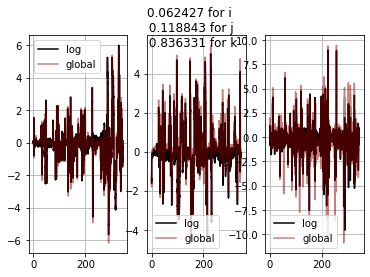

In [19]:




# %%% Comparison a i j k
Y=compute_acc_global(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global)

f=plt.figure()
ax=f.add_subplot(1,3,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(1,3,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(1,3,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  
c_k_=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  


s="%f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)



In [20]:


# %% Global 

def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H


def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(6)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k


def compute_acc_global(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data,vwi=0,vwj=0):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*Area*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect+np.c_[gammai,gammaj,gammak]+Fa


def cost_global_dij_(X):
    ct1,ct2,ch1,ch2,dij,dk=X

    Y=compute_acc_global(ct1,ct2,ch1,ch2,dij,dij,dk)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , cost :%f"%(ct1,ct2,ch1,ch2,dij,dij,dk,c))

    return c

X0_global_dij_=np.zeros(6)

sol_global_dij_=minimize(cost_global_dij_,X0_global_dij_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dk_global=sol_global_dij_['x']
dj_global=di_global


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122431
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :1.122434
ct1 :200.992918, ct2 :-1.898479 , ch1 :6.086671 , ch2 :-0.538691 , di :0.115226 , dj : 0.115226 , dk : -0.042146 , cost :4627


Performances: 
RMS error on acc pred is : 
IJ EQUAL 
 0.062503 for i 
 0.118686 for j 
 0.836377 for k


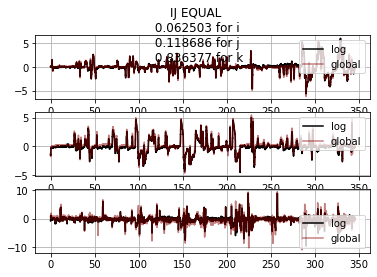

In [21]:

# %%% Comparison a i j k ij equal
Y=compute_acc_global(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global)

f=plt.figure()
ax=f.add_subplot(3,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  
c_k_=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  


s="IJ EQUAL \n %f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)




In [22]:


# %% WITH WIND 



def compute_acc_global_wind(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data,vwi=0,vwj=0):

    q0,q1,q2,q3=(prep_data['q[0]'],prep_data['q[1]'],
                 prep_data['q[2]'],prep_data['q[3]'])
    
    "precomputing transposition"
    R_transpose=np.array([tf3d.quaternions.quat2mat([i,j,k,l]).T for i,j,k,l in zip(q0,q1,q2,q3)])
    
    vw_earth=np.array([vwi,vwj,0])
    vw_body=R_transpose@vw_earth
    
    
    vai=df["speed_body[0]"]-vw_body[:,0]
    vaj=df["speed_body[1]"]-vw_body[:,1]
    vak=df["speed_body[2]"]-vw_body[:,2]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(6)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(6)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*Area*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect+np.c_[gammai,gammaj,gammak]+Fa


def cost_global_dij_wind_(X):
    ct1,ct2,ch1,ch2,dij,dk,vwi,vwj=X

    Y=compute_acc_global_wind(ct1,ct2,ch1,ch2,dij,dij,dk,vwi=vwi,vwj=vwj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , vwi : %f ,vwj : %f cost :%f"%(ct1,ct2,ch1,ch2,dij,dij,dk,vwi,vwj,c))

    return c


X0_global_dij_wind_=np.zeros(8)

sol_global_dij_wind_=minimize(cost_global_dij_wind_,X0_global_dij_wind_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dk_global,vwi_global_,vwj_global_=sol_global_dij_wind_['x']
dj_global=di_global


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.122431
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :1.122434
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , d


Performances: 
RMS error on acc pred is : 
WIND 
 0.159899 for i 
 0.167762 for j 
 0.616004 for k


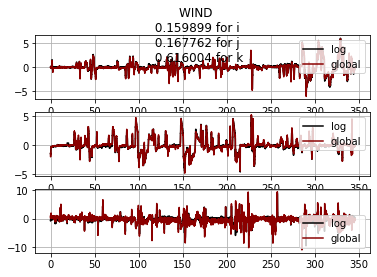

In [23]:
# % Comparison

Y=compute_acc_global_wind(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global,vwi=vwi_global_,vwj=vwj_global_)



f=plt.figure()
ax=f.add_subplot(3,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global")
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global")
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global")
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
# c_i_=np.sqrt(np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0))
# c_j_=np.sqrt(np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  )
# c_k_=np.sqrt(np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  )

c_i_=np.mean(np.abs(Y[:,0]-prep_data['acc_body_grad[0]']),axis=0)
c_j_=np.mean(np.abs(Y[:,1]-prep_data['acc_body_grad[1]']),axis=0)  
c_k_=np.mean(np.abs(Y[:,2]-prep_data['acc_body_grad[2]']),axis=0)  
s="WIND \n %f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)



In [24]:





# %% Synthesis


bilan=pd.DataFrame(data=None,
                    columns=['ct1','ct2',
                            'ch1','ch2',
                            'di','dj','dk','vwi','vwj',
                            'cost'],
                    index=['vanilla','custom',
                          'vanilla_dk','custom_with_dk',
                          'ai_drag','ai_h','ai_drag_and_h',
                          'aj_drag','aj_h','aj_drag_and_h',
                          'aij_h','aij_h_and_drag',
                          'aij_h_drag_equal_coeffs',
                          "global","global_equal_coeffs","global_wind"])




bilan.loc["vanilla"]['ct1','cost']=np.r_[sol_vanilla['x'],sol_vanilla['fun']]
bilan.loc["custom"]['ct1','ct2','cost']=np.r_[sol_custom['x'],sol_custom['fun']]

bilan.loc["vanilla_dk"]['ct1','dk','cost']=np.r_[sol_vanilla_drag['x'],sol_vanilla_drag['fun']]
bilan.loc["custom_with_dk"]['ct1','ct2','dk','cost']=np.r_[sol_custom_drag['x'],sol_custom_drag['fun']]

bilan.loc['ai_drag']['di','cost']=np.r_[sol_ai_od['x'],sol_ai_od['fun']]
bilan.loc['ai_h']['ch1','ch2','cost']=np.r_[sol_ai_oh['x'],sol_ai_oh['fun']]
bilan.loc['ai_drag_and_h']['ch1','ch2','di','cost']=np.r_[sol_ai_hwd['x'],sol_ai_hwd['fun']]

bilan.loc['aj_drag']['dj','cost']=np.r_[sol_aj_od['x'],sol_aj_od['fun']]
bilan.loc['aj_h']['ch1','ch2','cost']=np.r_[sol_aj_oh['x'],sol_aj_oh['fun']]
bilan.loc['aj_drag_and_h']['ch1','ch2','dj','cost']=np.r_[sol_aj_hwd['x'],sol_aj_hwd['fun']]


bilan.loc['aij_h']['ch1','ch2','cost']=np.r_[sol_aij_nodrag['x'],sol_aij_nodrag['fun']]
bilan.loc['aij_h_and_drag']['ch1','ch2','di','dj','cost']=np.r_[sol_aij_hwd['x'],sol_aij_hwd['fun']]

bilan.loc['aij_h_drag_equal_coeffs']['ch1','ch2','di','cost']=np.r_[sol_aij_hwd_di_eq_dj_['x'],sol_aij_hwd_di_eq_dj_['fun']]
bilan.loc['aij_h_drag_equal_coeffs']['dj']=bilan.loc['aij_h_drag_equal_coeffs']['di']

bilan.loc['global']['ct1','ct2',
                    'ch1','ch2',
                    'di','dj','dk',
                    'cost']=np.r_[sol_global_['x'],sol_global_['fun']]

bilan.loc['global_equal_coeffs']['ct1','ct2',
                    'ch1','ch2',
                    'di','dk',
                    'cost']=np.r_[sol_global_dij_['x'],sol_global_dij_['fun']]

bilan.loc['global_equal_coeffs']["dj"]=bilan.loc['global_equal_coeffs']["di"]

bilan.loc['global_wind']['ct1','ct2',
                    'ch1','ch2',
                    'di','dk','vwi','vwj',
                    'cost']=np.r_[sol_global_dij_wind_['x'],sol_global_dij_wind_['fun']]
bilan.loc['global_wind']["dj"]=bilan.loc['global_wind']["di"]




print(bilan)




                              ct1       ct2       ch1       ch2        di  \
vanilla                  0.000006       NaN       NaN       NaN       NaN   
custom                   0.017761  0.092429       NaN       NaN       NaN   
vanilla_dk               0.000006       NaN       NaN       NaN       NaN   
custom_with_dk           0.014791   0.05216       NaN       NaN       NaN   
ai_drag                       NaN       NaN       NaN       NaN  0.549261   
ai_h                          NaN       NaN  0.004145 -0.082715       NaN   
ai_drag_and_h                 NaN       NaN  0.003675 -0.081468  0.031293   
aj_drag                       NaN       NaN       NaN       NaN       NaN   
aj_h                          NaN       NaN   0.00171 -0.109422       NaN   
aj_drag_and_h                 NaN       NaN  0.001017 -0.107094       NaN   
aij_h                         NaN       NaN  0.002941 -0.095601       NaN   
aij_h_and_drag                NaN       NaN  0.002357 -0.093669  0.041796   